# Integration tests for the GoFigr Python client

In [1]:
TEST_RESULTS = []

In [2]:
import json
from platform import platform
def sync():
    with open("integration_test.json", "w") as f:
        json.dump({
            'platform': platform(),
            'results': TEST_RESULTS
            }, f, indent=4)

# Load the extension and publish a figure from the same cell

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'e7e4ecb9-885c-4d86-bd45-3ea9f2900a23')

Information about current cell is unavailable and certain features like source code capture will not work. Did you call configure() and try to publish a figure in the same cell? If so, we recommend keeping GoFigr configuration and figures in separate cells


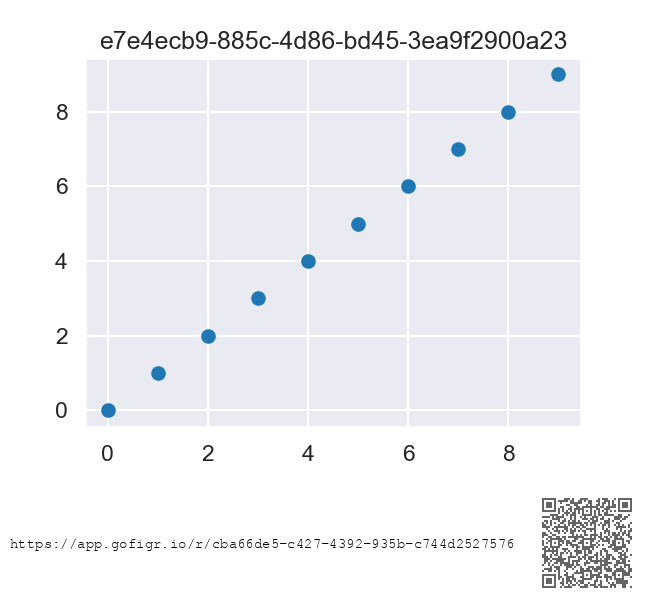

https://app-dev.gofigr.io/r/cba66de5-c427-4392-935b-c744d2527576


In [3]:
%load_ext gofigr
from gofigr.jupyter import *
import seaborn as sns
import matplotlib.pyplot as plt
import os

from uuid import uuid4
from gofigr.jupyter import _GF_EXTENSION as extension

sns.set_style("darkgrid")
sns.set_context("talk") 

configure(workspace=None,
          auto_publish=True,
          analysis=FindByName("Integration tests", create=True),
          username=os.environ['GF_TEST_USER'],
          password=os.environ['GF_TEST_PASSWORD'],
          url="https://api-dev.gofigr.io")

gf = get_gofigr()

# Try plotting in the same cell as configure(). auto_publish will break, but we should at least
# get a warning
fig_title1 = str(uuid4())
plt.figure()
plt.scatter(range(10), range(10))
plt.title(fig_title1)

In [4]:
shell = extension.shell

In [5]:
from collections import defaultdict

def check_text(txt, min_len=10):
    return txt is not None and txt.strip() not in ["N/A", "NA"] and len(txt.strip()) >= min_len

def check_figure(test_name, workspace, analysis_name, fig_name, expected_revisions=1):
    res = defaultdict(lambda: True)
    res["test_name"] = test_name
    res["error"] = None
    
    try:    
        ana = workspace.get_analysis(analysis_name, create=False)
        fig = ana.get_figure(fig_name, create=False)

        res["number_of_revisions"] = len(fig.revisions) == expected_revisions

        for rev in fig.revisions:
            rev.fetch()
            res["notebook_name"] = res["notebook_name"] and \
                check_text(rev.metadata["notebook_name"])
            res["notebook_path"] = res["notebook_path"] and \
                check_text(rev.metadata["notebook_path"]) and os.path.exists(rev.metadata["notebook_path"])
            res["cell_id"] = res["cell_id"] and check_text(rev.metadata["cell_id"], min_len=5)
            
            for img in rev.image_data:
                image_key = f"image_{img.format}" + ("_watermark" if img.is_watermarked else "")
                res[image_key] = res[image_key] and len(img.data) > 1000

            for code in rev.code_data:
                txt = code.contents.strip()
                res["cell_code"] = res["cell_code"] and check_text(txt)
                
            for td in rev.text_data:
                txt = td.contents.strip()
                res['text'] = res["text"] and check_text(txt)
                
    except Exception as e:
        res["error"] = str(e)
            
    return dict(res.items())

TEST_RESULTS.append(check_figure("Configure and publish in one cell", gf.primary_workspace, "Integration tests", fig_title1))
sync()

# Anonymous figure

Your figure doesn't have a title and will be published as 'Anonymous Figure'. To avoid this warning, set a figure title or manually call publish() with a target figure. See https://gofigr.io/docs/gofigr-python/latest/start.html#publishing-your-first-figure for an example.


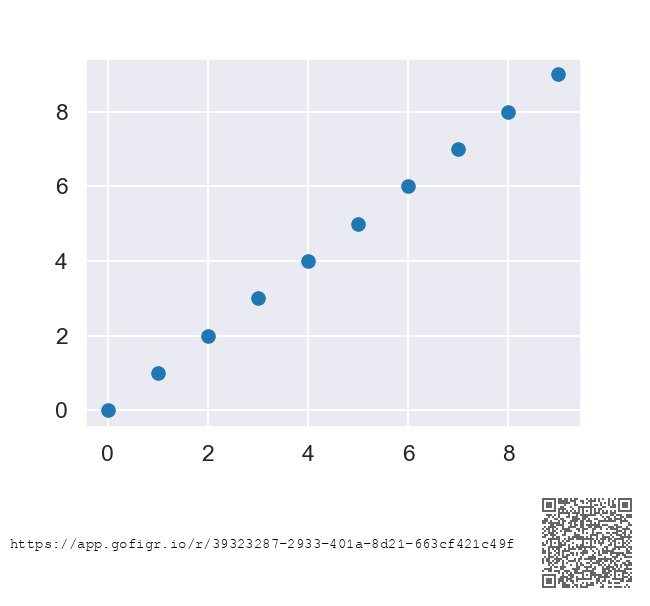

https://app-dev.gofigr.io/r/39323287-2933-401a-8d21-663cf421c49f


In [6]:
plt.scatter(x=range(10), y=range(10))

In [7]:
TEST_RESULTS.append(check_figure("Anonymous figure", gf.primary_workspace, "Integration tests", "Anonymous Figure"))
sync()

# Manual call to publish

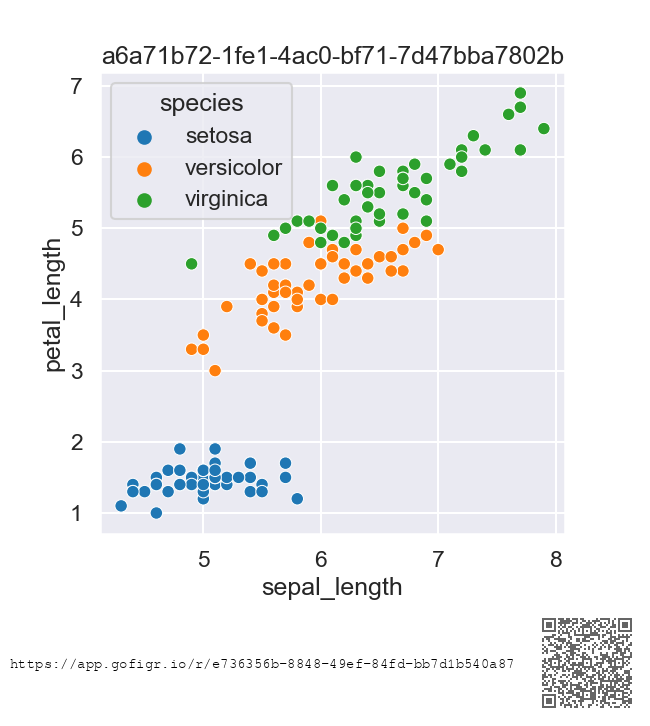

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


https://app-dev.gofigr.io/r/e736356b-8848-49ef-84fd-bb7d1b540a87


In [8]:
iris = sns.load_dataset("iris")

title2 = str(uuid4())

plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title2)

publish(target=FindByName(title2, create=True),
        dataframes={"IRIS": iris})

In [9]:
TEST_RESULTS.append(check_figure("Manual publish", gf.primary_workspace, "Integration tests", title2))
sync()

# Auto publish

Text(0.5, 1.0, 'fbccb5dc-15e2-41da-9ec5-5cfd32518db7')

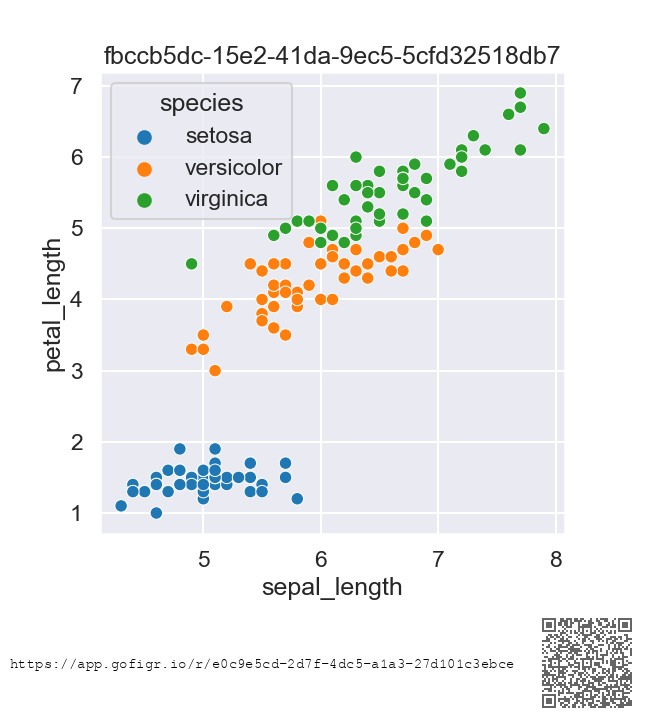

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


https://app-dev.gofigr.io/r/e0c9e5cd-2d7f-4dc5-a1a3-27d101c3ebce


In [10]:
iris = sns.load_dataset("iris")

title3 = str(uuid4())
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title3)

In [11]:
TEST_RESULTS.append(check_figure("Auto publish", gf.primary_workspace, "Integration tests", title3))
sync()

# Add revision

Text(0.5, 1.0, 'fbccb5dc-15e2-41da-9ec5-5cfd32518db7')

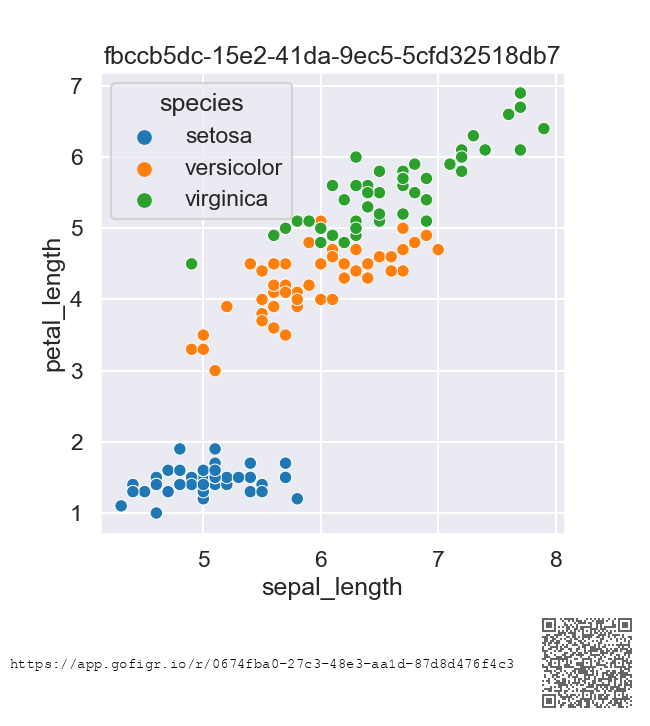

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


https://app-dev.gofigr.io/r/0674fba0-27c3-48e3-aa1d-87d8d476f4c3


In [12]:
# Add a new revision to the same figure
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title3)

In [13]:
TEST_RESULTS.append(check_figure("Auto-publish second revision", gf.primary_workspace, "Integration tests", title3,
                                expected_revisions=2))
sync()

# Inline backend

Text(0.5, 1.0, 'ccb5d4cb-b7b6-48af-a9bd-d87e2c2d76e6')

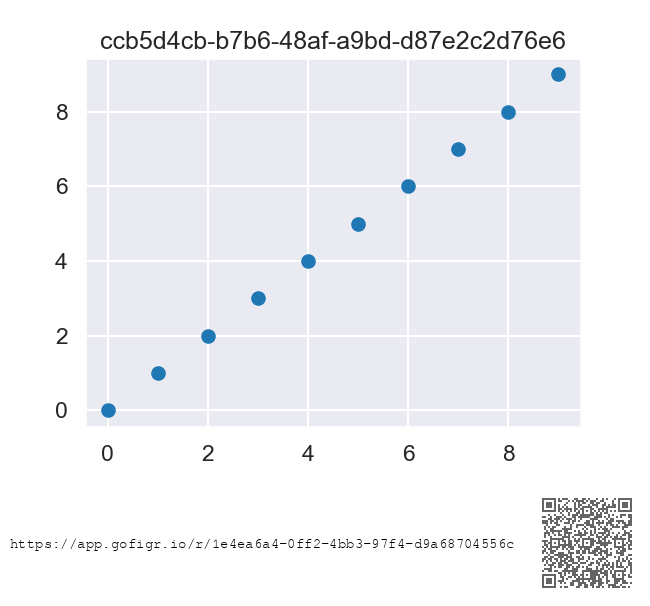

https://app-dev.gofigr.io/r/1e4ea6a4-0ff2-4bb3-97f4-d9a68704556c


In [14]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

title4 = str(uuid4())
plt.figure()
plt.scatter(range(10), range(10))
plt.title(title4)

In [15]:
TEST_RESULTS.append(check_figure("MPL inline backend", gf.primary_workspace, "Integration tests", title4))
sync()

# Mix-and-match manual and auto publish

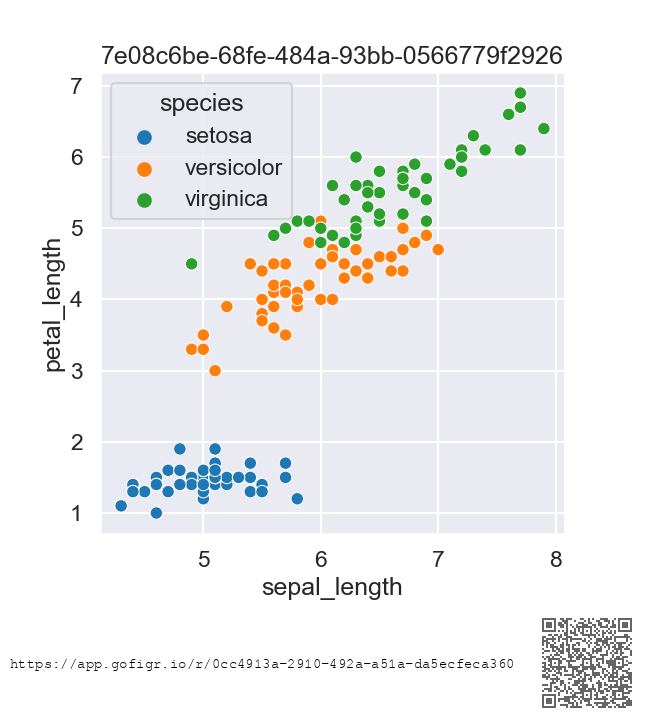

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


https://app-dev.gofigr.io/r/0cc4913a-2910-492a-a51a-da5ecfeca360


Text(0.5, 1.0, '7e08c6be-68fe-484a-93bb-0566779f2926')

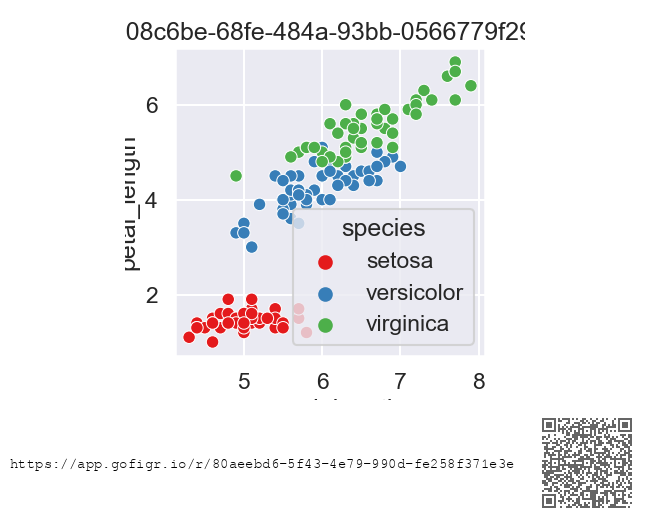

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


https://app-dev.gofigr.io/r/80aeebd6-5f43-4e79-990d-fe258f371e3e


In [16]:
title5 = str(uuid4())
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title5)
publish()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="Set1")
plt.title(title5)

In [17]:
TEST_RESULTS.append(check_figure("Mix manual and auto-publish", gf.primary_workspace, "Integration tests", title5, expected_revisions=2))
sync()

# Subplots

Text(0.5, 0.98, 'd6cc9a7c-9d86-42f7-8121-7a254671bfb3')

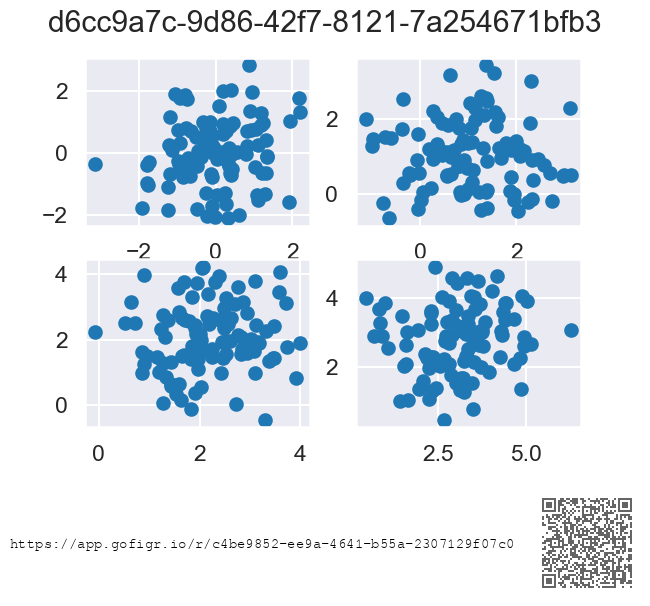

https://app-dev.gofigr.io/r/c4be9852-ee9a-4641-b55a-2307129f07c0


In [18]:
import numpy as np

title6 = str(uuid4())
fig, ax = plt.subplots(nrows=2, ncols=2)
ax = np.ravel(ax)

for idx, axis in enumerate(ax):
    axis.scatter(x=np.random.normal(loc=idx, size=100), y=np.random.normal(loc=idx, size=100))

fig.suptitle(title6)

In [19]:
TEST_RESULTS.append(check_figure("Subplots", gf.primary_workspace, "Integration tests", title6, expected_revisions=1))
sync()

# Plotly

## Static figure

In [33]:
plotly.io.kaleido.scope.default_width = 1920
plotly.io.kaleido.scope.default_height = 1080

Your figure doesn't have a title and will be published as 'Anonymous Figure'. To avoid this warning, set a figure title or manually call publish() with a target figure. See https://gofigr.io/docs/gofigr-python/latest/start.html#publishing-your-first-figure for an example.


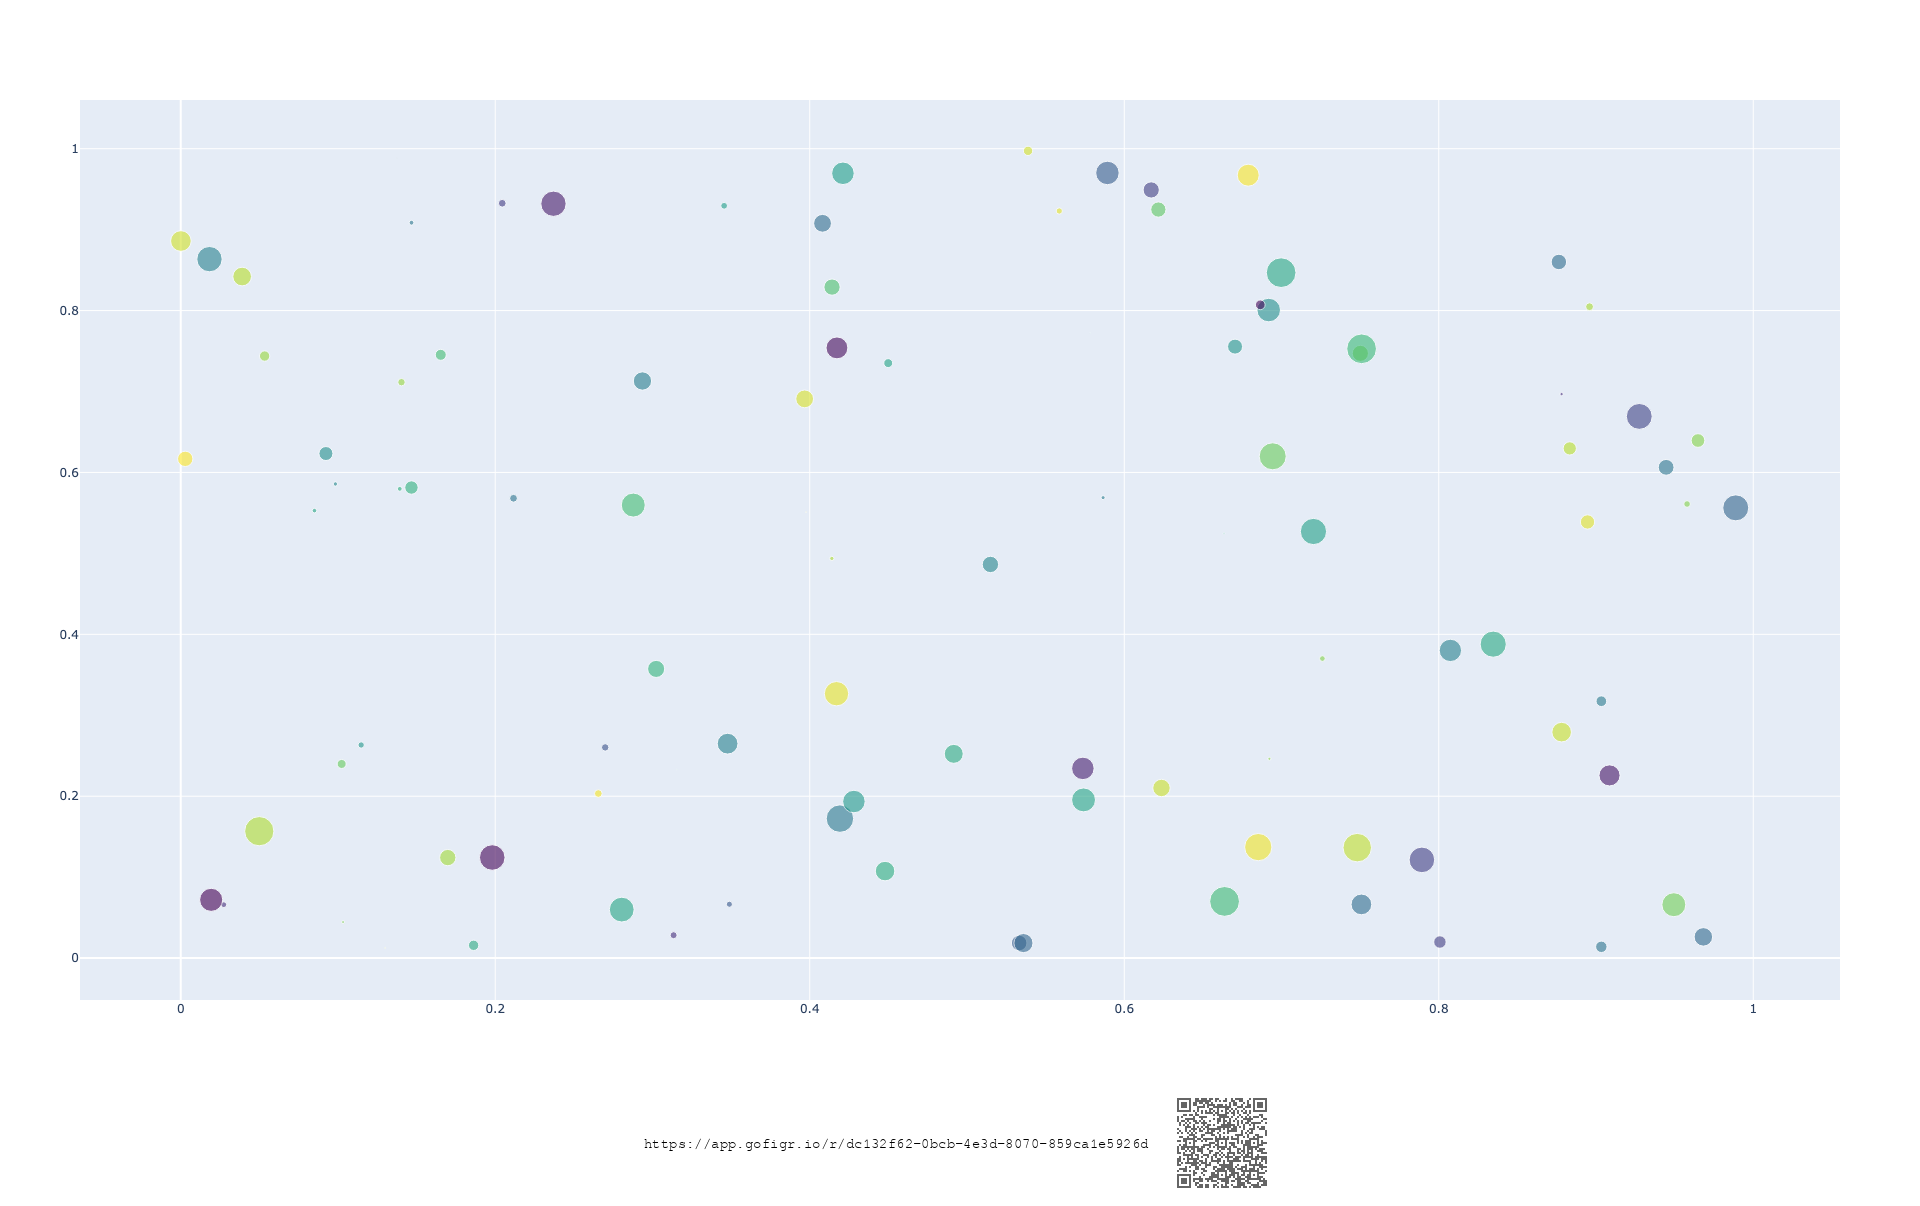

https://app-dev.gofigr.io/r/dc132f62-0bcb-4e3d-8070-859ca1e5926d


Plotly figure close is not implemented yet.


In [34]:
import plotly
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

N = 100
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
sz = np.random.rand(N) * 30

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    marker=go.scatter.Marker(
        size=sz,
        color=colors,
        opacity=0.6,
        colorscale="Viridis"
    )))

#fig.update_layout(
#        title=dict(
#            text="Plotly Scatter",
#))

fig.show()

publish(fig=fig)

In [22]:
fig.layout.title.text

'Plotly Scatter'

In [23]:
isinstance(fig, go.Figure)

True

In [24]:
shell.user_ns.items()

dict_items([('__name__', '__main__'), ('__doc__', 'Automatically created module for IPython interactive environment'), ('__package__', None), ('__loader__', None), ('__spec__', None), ('__builtin__', <module 'builtins' (built-in)>), ('__builtins__', <module 'builtins' (built-in)>), ('_ih', ['', 'TEST_RESULTS = []', 'import json\nfrom platform import platform\ndef sync():\n    with open("integration_test.json", "w") as f:\n        json.dump({\n            \'platform\': platform(),\n            \'results\': TEST_RESULTS\n            }, f, indent=4)', 'get_ipython().run_line_magic(\'load_ext\', \'gofigr\')\nfrom gofigr.jupyter import *\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport os\n\nfrom uuid import uuid4\nfrom gofigr.jupyter import _GF_EXTENSION as extension\n\nsns.set_style("darkgrid")\nsns.set_context("talk") \n\nconfigure(workspace=None,\n          auto_publish=True,\n          analysis=FindByName("Integration tests", create=True),\n          username=os.environ[

# Save results

In [25]:
import pandas as pd
pd.DataFrame(TEST_RESULTS)

,test_name,error,number_of_revisions,notebook_name,notebook_path,cell_id,image_png,image_png_watermark,image_eps,image_svg,cell_code,text
0,Configure and publish in one cell,None,True,True,True,False,True,True,True,True,False,True
1,Anonymous figure,None,False,True,False,False,True,True,False,True,False,True
2,Manual publish,None,True,True,True,False,True,True,True,True,True,True
3,Auto publish,None,True,True,True,False,True,True,True,True,True,True
4,Auto-publish second revision,None,True,True,True,False,True,True,True,True,True,True
5,MPL inline backend,None,True,True,True,False,True,True,True,True,True,True
6,Mix manual and auto-publish,None,True,True,True,False,True,True,True,True,True,True
7,Subplots,None,True,True,True,False,True,True,True,True,True,True


In [26]:
with open("integration_test.json.done", "w") as f:
    f.write("done\n")

In [27]:
!pwd

/Users/maciej/dev/gofigr-python/tests/integration
